<a href="https://colab.research.google.com/github/lwachowiak/Systematic-Analysis-of-Image-Schemas-through-Explainable-Multilingual-Language-Models/blob/main/Image_Schema_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
random_split_state=44  #1,2,3,42,44

In [ ]:
!pip install transformers
!pip install lime
!pip install sentencepiece

In [ ]:
import pandas as pd
import torch  
import sentencepiece
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import XLMRobertaTokenizer              #for loading the pretrained model and tokenizer
from transformers import XLMRobertaForSequenceClassification
from transformers import AdamW                            
from transformers import get_linear_schedule_with_warmup
from transformers import TextClassificationPipeline
from transformers import Trainer, TrainingArguments

from sklearn import preprocessing                         #for label encoding
from sklearn.metrics import classification_report         #for showing performance on validation/test sets
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ParameterGrid         #for grid search
from sklearn.model_selection import ParameterSampler      #for random search
from sklearn.utils.fixes import loguniform
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import time
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

import lime                                               #for XAI
from lime import lime_text

# Data Exploration

In [ ]:
df=pd.read_csv("IS_repository.csv")

In [ ]:
df.rename(columns = {'IMAGE_SCHEMA_ANNOTATION':'SuperordinateSchema'}, inplace = True)

**Basic Counts**

Check for and delete duplicates (no duplicates in final csv)

In [ ]:
df.drop_duplicates(subset ="LinguisticExamples", 
                     keep = "first", inplace = True) 
df

SENSORIMOTOR_SOURCE_DOMAIN  ... Unnamed: 13
0                        OBJECT  ...         NaN
1                        OBJECT  ...         NaN
2                        OBJECT  ...         NaN
3                        OBJECT  ...         NaN
4                        OBJECT  ...         NaN
...                         ...  ...         ...
2472                    SUPPORT  ...         NaN
2473                    SUPPORT  ...         NaN
2474                    SUPPORT  ...         NaN
2475                    SUPPORT  ...         NaN
2476                    SUPPORT  ...         NaN

[2477 rows x 14 columns]

In [ ]:
# column used for Image schema labels
df.SuperordinateSchema.value_counts()

CONTAINMENT          605
SOURCE_PATH_GOAL     466
OBJECT               417
VERTICALITY          321
FORCE                299
CENTER-PERIPHERY     136
SUBSTANCE             74
SCALE                 62
PART-WHOLE            30
CONTACT               30
SPLITTING             19
COVERING               7
SUPPORT                7
LINK                   4
Name: SuperordinateSchema, dtype: int64

In [ ]:
# how many unique methapors are there per image schema?
df.groupby('SuperordinateSchema')['CONCEPTUAL_METAPHOR'].nunique()

SuperordinateSchema
CENTER-PERIPHERY      28
CONTACT                5
CONTAINMENT           97
COVERING               4
FORCE                 65
LINK                   2
OBJECT               172
PART-WHOLE            10
SCALE                 16
SOURCE_PATH_GOAL      76
SPLITTING              5
SUBSTANCE             13
SUPPORT                3
VERTICALITY           51
Name: CONCEPTUAL_METAPHOR, dtype: int64

**Which words are the top words for each class?**

In [ ]:
#prepare count matrix

df_en=df.loc[df['Language'].isin(["en"])]
df_de=df.loc[df['Language'].isin(["de"])]

labels=list(df.SuperordinateSchema.unique())

is_texts_en=[''] * len(labels)
is_texts_de=[''] * len(labels)

#iterrate over dataframe and make one text block for each image schema
for i, row in df_en.iterrows():
  ind=labels.index(row["SuperordinateSchema"])
  is_texts_en[ind]+=row["LinguisticExamples"]

for i, row in df_de.iterrows():
  ind=labels.index(row["SuperordinateSchema"])
  is_texts_de[ind]+=row["LinguisticExamples"]


#create countvectorizer
vectorizer_en = CountVectorizer()
count_matrix_en = vectorizer_en.fit_transform(is_texts_en)
vectorizer_de = CountVectorizer()
count_matrix_de = vectorizer_de.fit_transform(is_texts_de)

In [ ]:
counts_en = pd.DataFrame(count_matrix_en.toarray(),
                  index=labels,
                  columns=vectorizer_en.get_feature_names())

counts_de = pd.DataFrame(count_matrix_de.toarray(),
                  index=labels,
                  columns=vectorizer_de.get_feature_names())

In [ ]:
# top words for containment
counts_en.T.sort_values(by="CONTAINMENT",ascending=False).head(10)

OBJECT  SOURCE_PATH_GOAL  PART-WHOLE  ...  SCALE  COVERING  SUPPORT
the      268               197           9  ...     15         8        7
in        52                71           2  ...      8         0        3
of       127                76           6  ...     15         4        3
out       13                13           0  ...      1         0        0
to       122                94           3  ...     13         4        1
he        38                59           3  ...     14         0        0
with      24                16           1  ...      1         0        0
into      13                15           2  ...      0         0        0
you       36                32           5  ...      3         0        0
his       26                27           2  ...      5         1        0

[10 rows x 14 columns]

In [ ]:
counts_de.T.sort_values(by="CONTAINMENT",ascending=False).head(10)

OBJECT  SOURCE_PATH_GOAL  PART-WHOLE  ...  SCALE  COVERING  SUPPORT
in         7                15           0  ...      1         0        0
der       19                33           0  ...      3         0        0
die       23                39           0  ...      2         0        0
aus        2                 2           0  ...      0         0        0
den        7                13           0  ...      0         0        0
und        5                 6           0  ...      0         0        0
im         4                 1           0  ...      0         0        0
welt       0                 1           0  ...      0         0        0
dem        3                10           0  ...      0         0        0
sich       3                 5           0  ...      0         0        0

[10 rows x 14 columns]

**Which Prep appears with which IS?**

In [ ]:
preps_en=['by', 'in', 'on', 'between', 'with', 'over', 'after', 'for', 'at', 'of', 'out',
 'within', 'before', 'until', 'through', 'upon', 'from', 'as', 'under', 'about',
 'up', 'into', 'onto', 'among', 'against', 'that', 'during', 'without',
 'behind', 'towards', 'beyond', 'along', 'like', 'around'
 , 'down', 'because', 'outside', 'off','below','near']

counts_en[preps_en]

by   in  on  between  ...  outside  off  below  near
OBJECT             15   52  29        2  ...        0    3      0     0
SOURCE_PATH_GOAL    7   71  22        1  ...        1    8      0     3
PART-WHOLE          1    2   0        0  ...        0    0      0     0
FORCE              14   41  13        2  ...        1    5      0     0
SUBSTANCE           0    1   2        0  ...        0    1      0     0
CONTAINMENT         5  120  12        0  ...        4    6      0     0
CENTER-PERIPHERY    3   12   6        4  ...        0    1      0     3
CONTACT             3    2   2        0  ...        0    0      0     1
VERTICALITY         0   28  15        0  ...        1    2      2     0
LINK                0    0   0        1  ...        0    0      0     0
SPLITTING           2    6   2        0  ...        0    0      0     0
SCALE               1    8   2        0  ...        0    1      0     0
COVERING            0    0   2        0  ...        0    0      0     0
SUPPORT             1    3   2        0  ...        0    0      0     0

[14 rows x 40 columns]

# Prepare Data for Classifier

Only keep classes considered in our analysis

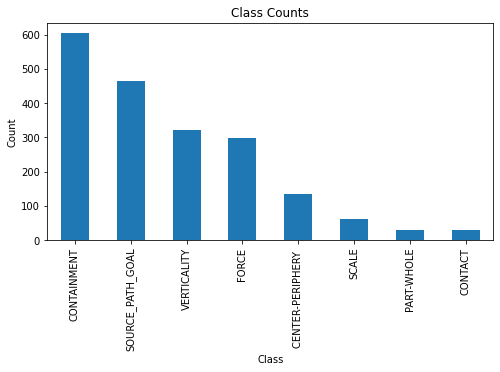

In [ ]:
df = df[df.SuperordinateSchema != "LINK"]
df = df[df.SuperordinateSchema != "OBJECT"]
df = df[df.SuperordinateSchema != "SUBSTANCE"]
df = df[df.SuperordinateSchema != "SPLITTING"]
df = df[df.SuperordinateSchema != "SUPPORT"]
df = df[df.SuperordinateSchema != "COVERING"]
df["SuperordinateSchema"].value_counts().plot(kind='bar', title='Class Counts', ylabel="Count", xlabel="Class", figsize=(8,4))

In [ ]:
df["SuperordinateSchema"].value_counts()

CONTAINMENT          605
SOURCE_PATH_GOAL     466
VERTICALITY          321
FORCE                299
CENTER-PERIPHERY     136
SCALE                 62
PART-WHOLE            30
CONTACT               30
Name: SuperordinateSchema, dtype: int64

In [ ]:
df["Language"].value_counts()

en    1534
de     414
Name: Language, dtype: int64

In [ ]:
df["SuperordinateSchema"].loc[df['Language'].isin(["en"])].value_counts()

CONTAINMENT          450
SOURCE_PATH_GOAL     367
FORCE                273
VERTICALITY          236
CENTER-PERIPHERY      96
SCALE                 52
PART-WHOLE            30
CONTACT               30
Name: SuperordinateSchema, dtype: int64

In [ ]:
df["SuperordinateSchema"].loc[df['Language'].isin(["de"])].value_counts()

CONTAINMENT          154
SOURCE_PATH_GOAL      99
VERTICALITY           85
CENTER-PERIPHERY      40
FORCE                 26
SCALE                 10
Name: SuperordinateSchema, dtype: int64

Encode labels as numbers 

In [ ]:
from sklearn import preprocessing                         #for label encoding

labels=list(df.SuperordinateSchema.unique())
print(labels)

le = preprocessing.LabelEncoder()
le.fit(labels)
df["SuperordinateSchema"]=le.transform(df["SuperordinateSchema"])

labels=le.classes_    #so it has  the same ordering....
print(labels)

['SOURCE_PATH_GOAL', 'PART-WHOLE', 'FORCE', 'CONTAINMENT', 'CENTER-PERIPHERY ', 'CONTACT', 'VERTICALITY', 'SCALE']
['CENTER-PERIPHERY ' 'CONTACT' 'CONTAINMENT' 'FORCE' 'PART-WHOLE' 'SCALE'
 'SOURCE_PATH_GOAL' 'VERTICALITY']


Train Test Split


In [ ]:
from sklearn.model_selection import train_test_split

train_data_all, test_data_all, y_train, y_test = train_test_split(df, df["SuperordinateSchema"], stratify=df["SuperordinateSchema"], test_size=0.2, random_state=random_split_state)   #RANDOM STATE SO IT IS ALWAYS THE SAME

In [ ]:
print("English Training Samples:", len(train_data_all.loc[train_data_all['Language'].isin(["en"])]))
print("German Training Samples: ", len(train_data_all.loc[train_data_all['Language'].isin(["de"])]))
print("English Test Samples:    ", len(test_data_all.loc[test_data_all['Language'].isin(["en"])]))
print("German Test Samples:     ", len(test_data_all.loc[test_data_all['Language'].isin(["de"])]))

English Training Samples: 1227
German Training Samples:  332
English Test Samples:     307
German Test Samples:      82


In [ ]:
# split validation data in german and english
test_data_en=test_data_all.loc[test_data_all['Language'].isin(["en"])]
test_data_de=test_data_all.loc[test_data_all['Language'].isin(["de"])]


Tokenizer

In [ ]:
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base" )

In [ ]:
def tokenizer_xlm(data, max_len):
  labels_ = []
  input_ids_ = []
  attn_masks_ = []

  # for each datasample:
  for index, row in data.iterrows():

      sentence = row['LinguisticExamples']

      # create requiered input, i.e. ids and attention masks
      encoded_dict = xlmr_tokenizer.encode_plus(sentence,
                                                max_length=max_len, 
                                                padding='max_length',
                                                truncation=True, 
                                                return_tensors='pt')

      # add encoded sample to lists
      input_ids_.append(encoded_dict['input_ids'])
      attn_masks_.append(encoded_dict['attention_mask'])
      labels_.append(row['SuperordinateSchema'])
      
  # Convert each Python list of Tensors into a 2D Tensor matrix.
  input_ids_ = torch.cat(input_ids_, dim=0)
  attn_masks_ = torch.cat(attn_masks_, dim=0)

  # labels to tensor
  labels_ = torch.tensor(labels_)

  print('Encoder finished. {:,} examples.'.format(len(labels_)))
  return input_ids_, attn_masks_, labels_

In [ ]:
#tokenize input for the different training/test sets
max_len=128

input_ids_train, attn_masks_train, labels_all_train = tokenizer_xlm(train_data_all, max_len)
input_ids_test, attn_masks_test, labels_all_test = tokenizer_xlm(test_data_all, max_len)
input_ids_test_de, attn_masks_test_de, labels_test_de = tokenizer_xlm(test_data_de, max_len)
input_ids_test_en, attn_masks_test_en, labels_test_en = tokenizer_xlm(test_data_en, max_len)

Encoder finished. 1,559 examples.
Encoder finished. 390 examples.
Encoder finished. 82 examples.
Encoder finished. 307 examples.


In [ ]:
# create datasets
train_dataset = TensorDataset(input_ids_train, attn_masks_train, labels_all_train)
test_dataset = TensorDataset(input_ids_test, attn_masks_test, labels_all_test)
test_dataset_de = TensorDataset(input_ids_test_de, attn_masks_test_de, labels_test_de)
test_dataset_en = TensorDataset(input_ids_test_en, attn_masks_test_en, labels_test_en)

In [ ]:
# create dataloaders
batch_size = 16

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size) #random sampling
test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset),batch_size = batch_size ) #sequential sampling
test_dataloader_de = DataLoader(test_dataset_de, sampler = SequentialSampler(test_dataset_de),batch_size = batch_size ) #sequential sampling
test_dataloader_en = DataLoader(test_dataset_en, sampler = SequentialSampler(test_dataset_en),batch_size = batch_size ) #sequential sampling

# Training

In [ ]:
def create_model(lr, eps, train_dataloader, epochs, device):
  print("num labels", len(labels))
  xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(labels))
  desc = xlmr_model.to(device)
  print('Connected to GPU:', torch.cuda.get_device_name(0))
  optimizer = AdamW(xlmr_model.parameters(),
                  lr = lr,   
                  eps = eps       
                )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,   
                                            num_training_steps = total_steps)
  return xlmr_model, optimizer, scheduler

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))  


In [ ]:
def validate(validation_dataloader, xlmr_model, verbose, print_cm, normalized=False): 
  
  # put model in evaluation mode 
  xlmr_model.eval()

  # Tracking variables 
  total_eval_loss = 0


  predictions, true_labels = [], []

  # Evaluate data for one epoch
  for batch in validation_dataloader:
          
      # Unpack training batch and copy the tensors to the gpu
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
          
      # no backprop needed
      with torch.no_grad():        

          # forward pass
          output =  xlmr_model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask,
                              labels=b_labels)
          loss=output.loss
          logits=output.logits
              
      # add up loss
      total_eval_loss += loss.item()

      # on cpu
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # save preds/true labels
      predictions.append(logits)
      true_labels.append(label_ids)

  # results of the whole validation set
  flat_predictions = np.concatenate(predictions, axis=0)
  flat_true_labels = np.concatenate(true_labels, axis=0)

  # logit to label
  predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

  # print classification report
  if verbose:
    print(classification_report(flat_true_labels, predicted_labels, labels=list(set(flat_true_labels))))

  # Calculate the validation accuracy, macro f1, and weighted f1
  val_accuracy = (predicted_labels == flat_true_labels).mean()
  macroP, macroR, macroF1, _ = precision_recall_fscore_support(flat_true_labels, predicted_labels, average="macro")#f1_score(flat_true_labels, predicted_labels, average='macro')
  weightedF1 = f1_score(flat_true_labels, predicted_labels, average='weighted')

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)

  # plot confusion matrix
  if print_cm:
    cm=confusion_matrix(flat_true_labels, predicted_labels, labels=list(range(0, len(labels))))
    if normalized:   
      cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      cm_normalized=np.round(cm_normalized,2)
      fig, ax = plt.subplots(figsize=(8,6))  
      plt.xlabel("Predicted")
      plt.ylabel("True")
      ax = sns.heatmap(cm_normalized, annot=True, linewidths=.5, xticklabels=labels, yticklabels=labels)
      plt.show()
    else:
      fig, ax = plt.subplots(figsize=(8,6))  
      plt.xlabel("Predicted")
      plt.ylabel("True")
      ax = sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, xticklabels=labels, yticklabels=labels)
      plt.show()

  return avg_val_loss, val_accuracy, macroF1, weightedF1
      

In [ ]:
def train_model(epochs, xlmr_model, train_dataloader, validation_dataloader, random_seed, verbose, optimizer, scheduler):

  seed_val = random_seed

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # mostly contains scores about how the training went for each epoch
  training_stats = []

  # total training time
  total_t0 = time.time()

  print('\033[1m'+"================ Model Training ================"+'\033[0m')

  # For each epoch...
  for epoch_i in range(0, epochs):

      print("")
      print('\033[1m'+'======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs)+'\033[0m')

      t0 = time.time()

      # summed training loss of the epoch
      total_train_loss = 0


      # model is being put into training mode as mechanisms like dropout work differently during train and test time
      xlmr_model.train()

      # iterrate over batches
      for step, batch in enumerate(train_dataloader):

          # unpack training batch at load it to gpu (device)  
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # clear gradients before calculating new ones
          xlmr_model.zero_grad()        

          # forward pass with current batch

          output=xlmr_model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask, 
                              labels=b_labels
                              )
          loss=output.loss
          logits=output.logits

          # add up the loss
          total_train_loss += loss.item()

          # calculate new gradients
          loss.backward()

          # gradient clipping (not bigger than)
          torch.nn.utils.clip_grad_norm_(xlmr_model.parameters(), 1.0)

          # Update the networks weights based on the gradient as well as the optimiziers parameters
          optimizer.step()

          # lr update
          scheduler.step()

      # avg loss over all batches
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # training time of this epoch
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
  
      # VALIDATION
      print("evaluate")
      if epoch_i==epochs-1:print_cm=True #Print out cm in final iteration
      else: print_cm=False
      avg_val_loss, val_accuracy, macroF1, weightedF1_no_random = validate(validation_dataloader, xlmr_model, verbose, print_cm)   
       

      print('\033[1m'+ "  Validation Loss All: {0:.2f}".format(avg_val_loss) + '\033[0m')

      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss all': avg_val_loss,
              'Valid. Accur.': val_accuracy,
              'Weigh_F1 all': weightedF1_no_random, 
              'Macro F1 all': macroF1,
              'Training Time': training_time,
          }
      )

  print("\n\nTraining complete!")
  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  
  return training_stats


In [ ]:
lr=3e-5
eps=1e-8
epochs=12
device = torch.device('cuda')
xlmr_model, optimizer, scheduler = create_model(lr=lr, eps=eps, train_dataloader=train_dataloader, epochs=epochs, device=device)

num labels 8


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Connected to GPU: Tesla P100-PCIE-16GB


================ Model Training ================

======== Epoch 1 / 12 ========

  Average training loss: 1.76
  Training epoch took: 0:00:24
evaluate


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00         6
           2       0.55      0.75      0.64       121
           3       0.12      0.02      0.03        60
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00        13
           6       0.45      0.86      0.59        93
           7       0.73      0.47      0.57        64

    accuracy                           0.52       390
   macro avg       0.23      0.26      0.23       390
weighted avg       0.42      0.52      0.44       390

  Validation Loss All: 1.49

======== Epoch 2 / 12 ========

  Average training loss: 1.30
  Training epoch took: 0:00:24
evaluate
              precision    recall  f1-score   support

           0       0.62      0.30      0.40        27
           1       0.00      0.00      0.00         6
           2       0.60      0.92      0.72       121
 

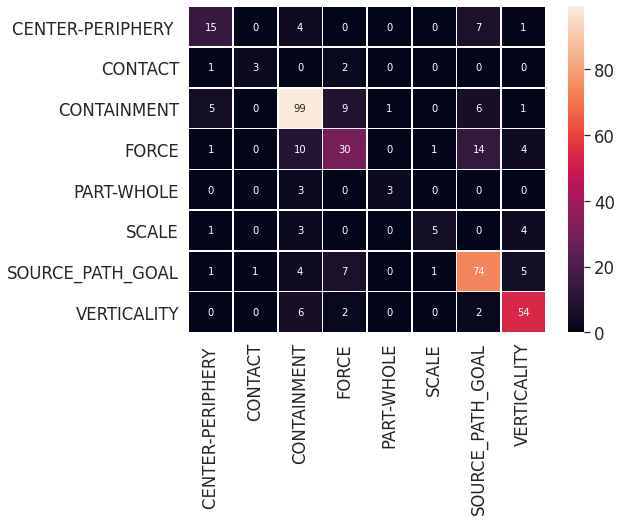

  Validation Loss All: 1.38


Training complete!
Total training took 0:05:01 (h:mm:ss)


In [ ]:
#mit 12 epochs und 3e-5
training_stats=train_model(epochs=epochs,
                           xlmr_model=xlmr_model,
                           train_dataloader=train_dataloader,
                           validation_dataloader=test_dataloader,
                           random_seed=42,
                           verbose=True,
                           optimizer=optimizer,
                           scheduler=scheduler)

In [ ]:
# save model
PATH="saved_models/iscat0404_crossval5"
#xlmr_model.save_pretrained(PATH)

In [ ]:
#load
xlmr_model= XLMRobertaForSequenceClassification.from_pretrained(PATH)
xlmr_model.to(device)

# Additional Evaluation

              precision    recall  f1-score   support

           0       0.56      0.48      0.51        21
           1       0.75      0.50      0.60         6
           2       0.74      0.79      0.77        91
           3       0.67      0.53      0.59        55
           4       0.75      0.50      0.60         6
           5       0.71      0.38      0.50        13
           6       0.69      0.80      0.74        71
           7       0.76      0.89      0.82        44

    accuracy                           0.71       307
   macro avg       0.70      0.61      0.64       307
weighted avg       0.71      0.71      0.70       307



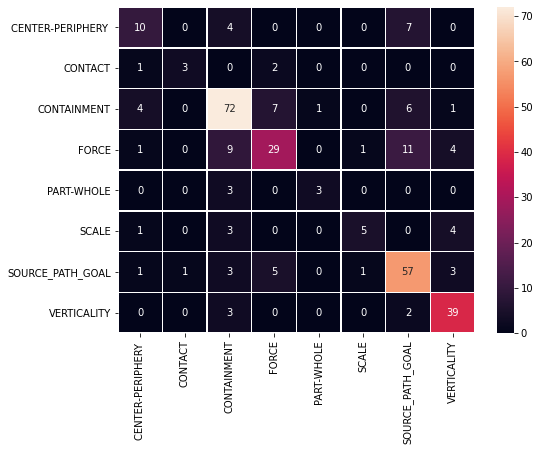

In [ ]:
# validate on english
_,_,_,_=validate(test_dataloader_en, xlmr_model, True, True)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           2       0.84      0.90      0.87        29
           3       0.14      0.20      0.17         5
           6       0.85      0.77      0.81        22
           7       0.83      0.75      0.79        20

    accuracy                           0.78        82
   macro avg       0.70      0.69      0.69        82
weighted avg       0.80      0.78      0.79        82



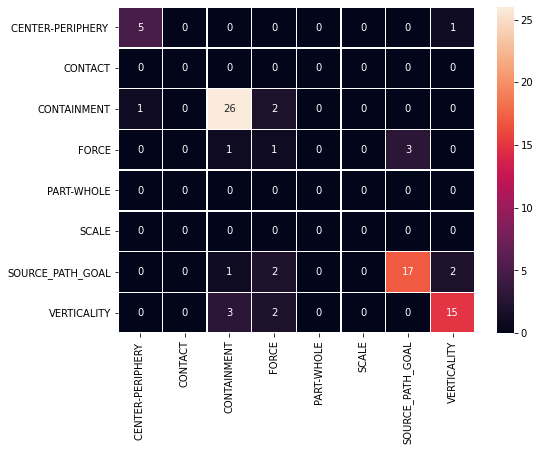

In [ ]:
# validate on german
_,_,_,_=validate(test_dataloader_de, xlmr_model, True, True)

In [ ]:
# Table with training stats
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

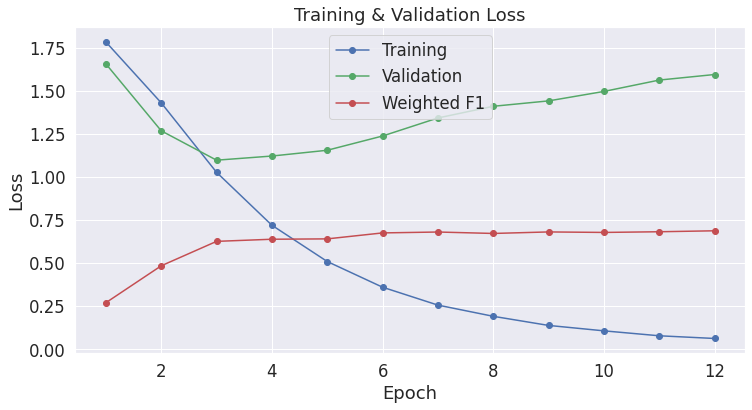

In [ ]:
# Plot Trainingloss, Validation loss and Weighted F1 score for each epoch

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss all'], 'g-o', label="Validation")
plt.plot(df_stats['Weigh_F1 all'], 'r-o', label="Weighted F1")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Lime 

In [ ]:
# returns softmax (from the logits in our case)
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div

#wrapper for our model to work with lime
def pred_for_lime(sentences):
    predictions=np.empty(shape=(len(sentences),len(labels)))    #needs to contain probabilites
    for i, sentence in enumerate(sentences):
        #prepare input and make prediction
        xlmr_model.eval()
        encoded_dict = xlmr_tokenizer.encode_plus(sentence,
                                                max_length=max_len, 
                                                padding='max_length',
                                                truncation=True, 
                                                return_tensors='pt')
        input_id=encoded_dict['input_ids'].to(device)
        attn_mask=encoded_dict['attention_mask'].to(device)
        label=torch.tensor(0).to(device)      
        output =  xlmr_model(input_id, 
                              token_type_ids=None, 
                              attention_mask=attn_mask,
                              labels=label)
        loss=output.loss
        logits=output.logits            
        logits = logits.detach().cpu().numpy()
        prob_preds=softmax(logits)
        #print(sentence)
        #print(prob_preds)
        #print(logits)
        predictions[i]=prob_preds
    return predictions

In [ ]:
explainer = lime_text.LimeTextExplainer(class_names=labels, verbose=False)

# Manually checking confusion pairs 

In [ ]:
def xlmr_predict(model, sentence, label):
        model.eval()
        encoded_dict = xlmr_tokenizer.encode_plus(sentence,
                                                max_length=max_len, 
                                                padding='max_length',
                                                truncation=True, 
                                                return_tensors='pt')
        input_id=encoded_dict['input_ids'].to(device)
        attn_mask=encoded_dict['attention_mask'].to(device)
        label=torch.tensor(0).to(device) 
        #no gradients are computed making everything faster
        with torch.no_grad():                 
          output = model(input_id, 
                                      token_type_ids=None, 
                                      attention_mask=attn_mask,
                                      labels=label)
          logits=output.logits
        logits = logits.detach().cpu().numpy()
        prob_preds=softmax(logits)
        return prob_preds

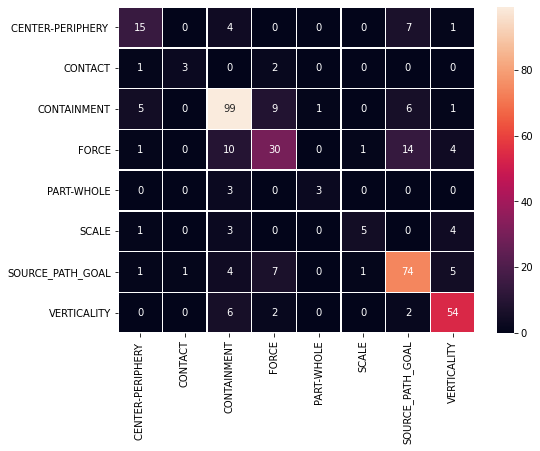

In [ ]:
_,_,_,_=validate(test_dataloader, xlmr_model, False, True, False)

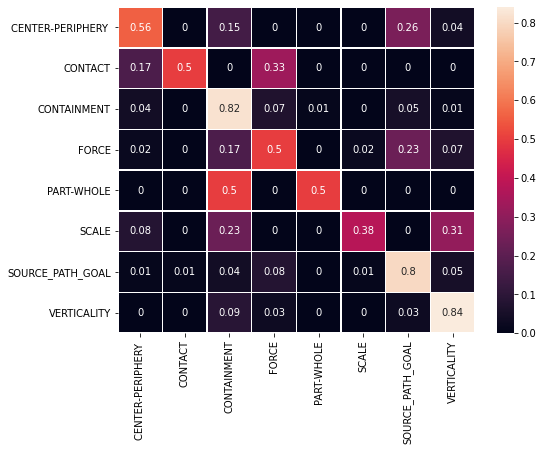

In [ ]:
_,_,_,_=validate(test_dataloader, xlmr_model, False, True,True)

In [ ]:
#SCALE predicted as VERTICALITY
for i, row in test_data_all.iterrows():
  pred = labels[np.argmax(xlmr_predict(xlmr_model, row["LinguisticExamples"], 0)[0])]
  if labels[row["SuperordinateSchema"]]=="SCALE" and pred=="VERTICALITY":
    print(row["LinguisticExamples"], row["SuperordinateSchema"])
    exp = explainer.explain_instance(row["LinguisticExamples"], pred_for_lime, num_features=5, top_labels=7, num_samples=500)
    exp.show_in_notebook()

He’s head and shoulders above everyone in the industry. 5


Maslow is a towering figure in humanistic psychology. 5


The number of available parking spaces continues to shrink.  5


He stands head and shoulders above them. 5


# Global Explanation Stats with LIME

In [ ]:
#global explanation stats over all test samples
len(test_data_en)

307

In [ ]:
#iterrate over test set 

results=[]
for i in labels: results.append({})

for i, row in test_data_en.iterrows():


  
  exp = explainer.explain_instance(row["LinguisticExamples"], pred_for_lime, num_features=20, top_labels=8, num_samples=500)
  #exp.show_in_notebook()

  pred_index=exp.top_labels[0]
  importance_list=exp.as_list(label=pred_index)

  print(row["LinguisticExamples"])
  print(exp.as_list(label=exp.top_labels[0]))

  #save word score of top prediction
  for word,importance in importance_list:
    #word=exp.as_list(label=pred_index)[0][0]
    #importance=exp.as_list(label=pred_index)[0][1]
    if word in results[pred_index]:
      results[pred_index][word].append(importance)
    else:
      results[pred_index][word]=[importance]

print(results)



  


In [ ]:
 print(results)

[{'here': [0.7986126510706762], 'central': [-0.0991385574228188], 'is': [0.062194359213326826, -0.017344143193636825], 'What': [0.007228951549410694], 'clock': [0.28430291782166495], 'approaching': [0.2680369150245609], 'O': [0.21719047034417316], 'Three': [0.022280420675340744], 'NEXT': [0.5270828354707975], 'TO': [0.27410559681487245], 'POVERTY': [-0.14124041864916176], 'AND': [0.12113331237691134], 'OF': [0.09754398192933054], 'PROSPERITY': [-0.06335238063281119], 'OCEANS': [0.056746655761787404], 'CANNOT': [-0.05186158444181582], 'SQUALOR': [0.030279455851843995], 'ISLANDS': [0.025703435716115663], 'WE': [0.018052640261080475], 'HAVE': [-0.002909358937855359], 'near': [0.1949450673038331], 'dear': [0.17255585703956258], 'us': [0.08535936399520086], 'should': [0.0594499057306346], 'who': [0.04087099049743327, -0.015997225294918527], 'People': [0.022221798495786937, -0.017494616523329953], 'are': [-0.018429114212925635, -0.022701851084311546, 0.012245830980513819, 0.04289745263592363

In [ ]:
results_average=[]
results_amount=[]
for l in results:
  d_avg={}
  d_amount={}
  for word in l:
    average=sum(l[word])/len(l[word])
    amount=len(l[word])
    d_avg[word]=average
    d_amount[word]=amount
  results_average.append(d_avg)
  results_amount.append(d_amount)

In [ ]:
containment_res=sorted(results_average[2].items(), key=lambda item: item[1], reverse=True)[0:10]
containment_res.reverse()
containment_res

[('exert', 0.6234347921281501),
 ('white', 0.6819708350368962),
 ('entered', 0.7245045907659161),
 ('answer', 0.7525547872183224),
 ('diverse', 0.8054019335244115),
 ('broad', 0.8728966311075826),
 ('fullest', 0.8860281922418659),
 ('contain', 0.9046560854001042),
 ('attractive', 0.9065699828277687),
 ('beyond', 0.9506379970897643)]

CENTER-PERIPHERY 
[('out', 0.2869831705674827), ('friends', 0.32264955148391433), ('further', 0.3802174480669501), ('touch', 0.41219215282363175), ('close', 0.44484782028065484), ('NEXT', 0.5270828354707975), ('closely', 0.6783342269294341), ('closest', 0.7924564139369533), ('here', 0.7986126510706762), ('away', 0.8141519186856353), ('distant', 0.8540022722644768), ('Here', 0.8980444532729108), ('borderline', 0.9125323115074989), ('remote', 0.9194233590274177), ('borders', 0.9416630334441025)]


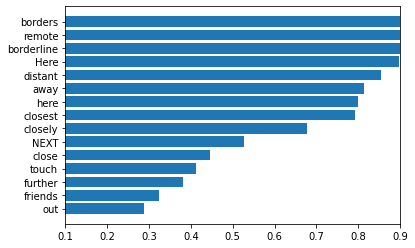

CONTACT
[('got', 0.003974361772787614), ('That', 0.008141367966278592), ('really', 0.02222154301563767), ('made', 0.039163241515525415), ('an', 0.06373562815118652), ('He', 0.08724078293203165), ('himself', 0.10403138588882253), ('my', 0.10436239949753272), ('impression', 0.21258714455775274), ('me', 0.2667425762568265), ('hanging', 0.3410332697895317), ('to', 0.401029597858384), ('her', 0.4270030043132686), ('fingertips', 0.4768060194051472), ('shields', 0.6122035671626229)]


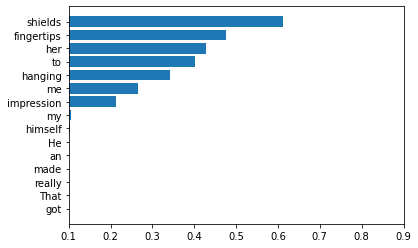

CONTAINMENT
[('into', 0.5433603931048332), ('eating', 0.5645504634588867), ('handouts', 0.6122262600356656), ('out', 0.6203282823498416), ('feeding', 0.6222695862786874), ('exert', 0.6234347921281501), ('white', 0.6819708350368962), ('entered', 0.7245045907659161), ('answer', 0.7525547872183224), ('diverse', 0.8054019335244115), ('broad', 0.8728966311075826), ('fullest', 0.8860281922418659), ('contain', 0.9046560854001042), ('attractive', 0.9065699828277687), ('beyond', 0.9506379970897643)]


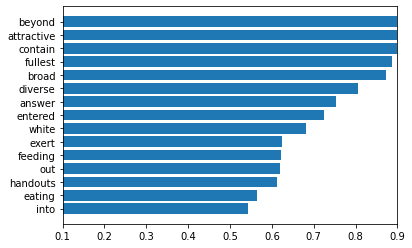

FORCE
[('surges', 0.608088526226121), ('blew', 0.6173821915226335), ('sour', 0.6892647799331477), ('weigh', 0.6904232155894482), ('swept', 0.6905859378688181), ('battered', 0.6945370745151923), ('transported', 0.7251572027479539), ('drew', 0.7330581675399502), ('charged', 0.7407848292908258), ('momentum', 0.7919806139301055), ('struck', 0.8009363819684537), ('wave', 0.8529995693105489), ('blow', 0.877650445331252), ('crazy', 0.9119220645762106), ('downhill', 0.9168466845055875)]


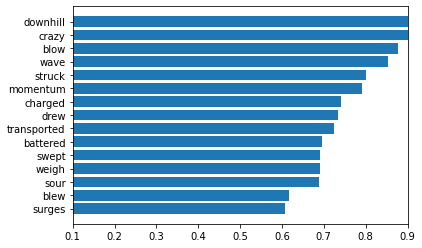

PART-WHOLE
[('She', 0.07926992441079306), ('galaxy', 0.09068209761793213), ('joke', 0.09813908523872354), ('theory', 0.09840152512012151), ('They', 0.1177367442890788), ('least', 0.1257248947858133), ('has', 0.13710164790741186), ('splittingly', 0.15167744307057549), ('my', 0.15297208118598596), ('funny', 0.17251188468218445), ('other', 0.21891571889831324), ('planets', 0.33768687325335195), ('half', 0.5948428027972597), ('side', 0.7652907535456466), ('assembled', 0.8226926643211605)]


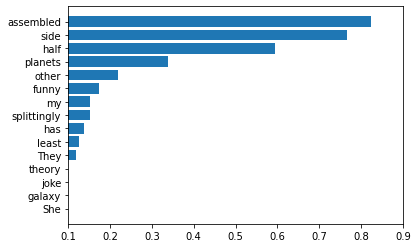

SCALE
[('a', 0.011865397776189385), ('That', 0.012479036104955534), ('s', 0.014593699469521493), ('two', 0.02113886784852628), ('anything', 0.023212459968751018), ('problem', 0.02617796759250823), ('This', 0.03714370892620695), ('He', 0.06931988925879415), ('conference', 0.08659517650272541), ('Let', 0.10721385209347836), ('spread', 0.5455553374960346), ('amount', 0.8585667143342631), ('substantial', 0.8873643650013301), ('big', 0.9277095495259159), ('bigger', 0.9595905397476363)]


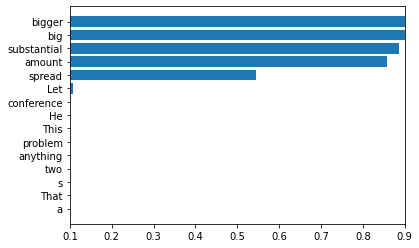

SOURCE_PATH_GOAL
[('gone', 0.5393903355553774), ('passage', 0.5699211352769746), ('marriage', 0.5702413660018959), ('invading', 0.5834699192183841), ('Upcoming', 0.6057529295836288), ('forward', 0.6151499329889852), ('rest', 0.623241567101775), ('lateral', 0.6643291126792644), ('behind', 0.6895789452966994), ('rule', 0.7107461949200442), ('closer', 0.7175241824480798), ('walking', 0.8081816479005298), ('follow', 0.8367655964387827), ('standoffish', 0.8576727584176577), ('track', 0.9488266758068266)]


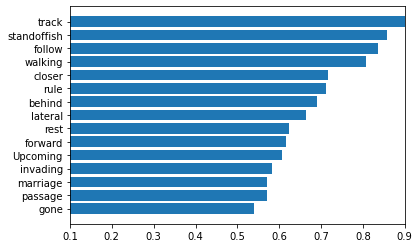

VERTICALITY
[('wing', 0.6299962490515247), ('heights', 0.6394705776306499), ('subside', 0.6576584762325397), ('up', 0.6679751262299064), ('surface', 0.6695553575873321), ('sliding', 0.6826588946867588), ('above', 0.7605714278075704), ('towering', 0.8110507511877663), ('decline', 0.8149583796041966), ('upward', 0.8570235086555631), ('top', 0.8622895040278653), ('shrink', 0.8646392269759698), ('peak', 0.9123459726078783), ('lifted', 0.9359591745511673), ('submissive', 0.9418849285956036)]


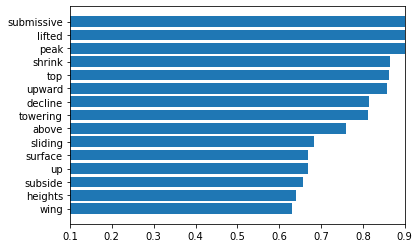

In [ ]:
for i in range(len(labels)):
  print(labels[i])
  res=sorted(results_average[i].items(), key=lambda item: item[1], reverse=True)[0:15]
  res.reverse()
  print(res)
  plt.barh(range(len(res)), [val[1] for val in res], align='center')
  plt.yticks(range(len(res)), [val[0] for val in res])
  plt.xlim(0.1,0.9)
  plt.show()

#Zero-Shot Performance

**Mandarin**

In [ ]:
df_mandarin=pd.read_excel('Mandarin.xlsx')  
df_mandarin["SuperordinateSchema"]=df_mandarin["SuperordinateSchema"].replace("PATH", "SOURCE_PATH_GOAL")
df_mandarin

SENSORIMOTOR_SOURCE_DOMAIN  ...                  [SOURCE]
0                    UP-DOWN   ...  [Lai & Boroditsky, 2013]
1                    UP-DOWN   ...  [Lai & Boroditsky, 2013]
2                    UP-DOWN   ...  [Lai & Boroditsky, 2013]
3                    UP-DOWN   ...  [Lai & Boroditsky, 2013]
4                    UP-DOWN   ...  [Lai & Boroditsky, 2013]
..                        ...  ...                       ...
56                        NaN  ...                [Yu, 2003]
57                        NaN  ...                [Yu, 2003]
58                        NaN  ...                [Yu, 2003]
59                        NaN  ...                [Yu, 2003]
60                        NaN  ...                [Yu, 2003]

[61 rows x 9 columns]

In [ ]:
df_mandarin.SuperordinateSchema.value_counts()

VERTICALITY         19
CONTAINMENT         18
SOURCE_PATH_GOAL    18
BASIC                6
Name: SuperordinateSchema, dtype: int64

In [ ]:
df_mandarin = df_mandarin[df_mandarin.SuperordinateSchema != "BASIC"]
df_mandarin["SuperordinateSchema"]=le.transform(df_mandarin["SuperordinateSchema"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
input_ids_test_zh, attn_masks_test_zh, labels_all_test_zh = tokenizer_xlm(df_mandarin, max_len)
test_dataset_zh = TensorDataset(input_ids_test_zh, attn_masks_test_zh, labels_all_test_zh)
test_dataloader_zh = DataLoader(test_dataset_zh, sampler = SequentialSampler(test_dataset_zh),batch_size = batch_size ) #sequential sampling

Encoder finished. 55 examples.


              precision    recall  f1-score   support

           2       0.69      0.50      0.58        18
           6       0.73      0.61      0.67        18
           7       0.93      0.68      0.79        19

   micro avg       0.79      0.60      0.68        55
   macro avg       0.78      0.60      0.68        55
weighted avg       0.79      0.60      0.68        55



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


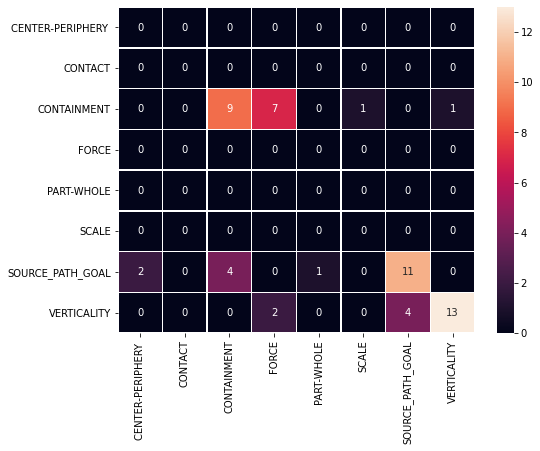

In [ ]:
avg_val_loss, val_accuracy, macroF1, weightedF1=validate(test_dataloader_zh, xlmr_model, True, True)

**Russian**

In [ ]:
df_russian=pd.read_csv('Image Schemas Russian.csv')  

In [ ]:
df_russian = df_russian.rename(columns={'Russian': 'LinguisticExamples', 'ImageSchema': 'SuperordinateSchema'})
df_russian["SuperordinateSchema"]=df_russian["SuperordinateSchema"].replace("PATH", "SOURCE_PATH_GOAL")
df_russian = df_russian[df_russian.SuperordinateSchema != "LINK"]
df_russian = df_russian[df_russian.SuperordinateSchema != "OBJECT"]
df_russian = df_russian[df_russian.SuperordinateSchema != "SUBSTANCE"]
df_russian["SuperordinateSchema"]=le.transform(df_russian["SuperordinateSchema"])
df_russian

LinguisticExamples  ... Unnamed: 8
0   Если какой-то книги нет в продаже, потому что ...  ...        NaN
1   GAFA  постепенно устраняют конкуренцию на рынк...  ...        NaN
2                              Она идёт в библиотеку.  ...        NaN
3                     Мама, поедем в книжный магазин!  ...        NaN
4   Подаче иска предшествовал представленный в нач...  ...        NaN
5            Wallmart, крупнейшая розничная сеть США,  ...        NaN
6    «Усиление конкуренции после дела Microsoft по...  ...        NaN
8   отложим в сторону проблему социального контрол...  ...        NaN
9   разных групп пользователей поведение в интерне...  ...        NaN
10   и не было на свете такой силы, которая смогла...  ...        NaN
11  Даже если его лично еще совершенно этот кризис...  ...        NaN
12                          как Бог коснулся их жизни  ...        NaN
13  Что жизнь понимали и ценили друг друга, чтобы ...  ...        NaN
14   Всё это как кусочки пазла , из которых склады...  ...        NaN
15                      Он развалился на части и умер  ...        NaN
18  Парламентарии уверены, что руководство страны ...  ...        NaN
19  Эта культура создавалась интровертами – разраб...  ...        NaN
20  которые не останавливаются перед препятствиями...  ...        NaN
21  Именно предприниматели меняют мир и двигают ег...  ...        NaN
22  Одно дело, когда просто снижается спрос или об...  ...        NaN
23  Общее отношение граждан к предпринимательству ...  ...        NaN
24  Нельзя, чтобы естественная монополия была в ча...  ...        NaN
25  Вот это, на мой взгляд, конечно, путь не то чт...  ...        NaN
26  Основой эффективного управления взаимоотношени...  ...        NaN
27  Под руководством Фергюсона «Манчестер Юнайтед»...  ...        NaN
28   Трейдеры, достигшие более высоких уровней успеха  ...        NaN
29  И пусть жанр сериала низкий, зато ТНТ достиг в...  ...        NaN
30  Время человеческой жизни – миг; ее сущность – ...  ...        NaN
31  Если удастся выстроить отношения с собакой дол...  ...        NaN
33       На заводе высокие по меркам отрасли зарплаты  ...        NaN
34  Локации с высоким положительным рейтингом стан...  ...        NaN
36                  Кто достиг вершины, тот идет вниз  ...        NaN
37  Но будут ли тронуты "сердца" Hewlett-Packard и...  ...        NaN
38              Работать рядом с гигантами интереснее  ...        NaN
39   Была большая надежда на этот аппарат и ту отняли  ...        NaN

[35 rows x 9 columns]

In [ ]:
input_ids_test_ru, attn_masks_test_ru, labels_all_test_ru = tokenizer_xlm(df_russian, max_len)
test_dataset_ru = TensorDataset(input_ids_test_ru, attn_masks_test_ru, labels_all_test_ru)
test_dataloader_ru = DataLoader(test_dataset_ru, sampler = SequentialSampler(test_dataset_ru),batch_size = batch_size ) #sequential sampling

Encoder finished. 35 examples.


              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       1.00      0.67      0.80         3
           2       0.60      1.00      0.75         3
           3       0.33      0.33      0.33         3
           4       0.67      0.67      0.67         3
           5       0.67      0.40      0.50         5
           6       0.64      1.00      0.78         7
           7       0.83      0.83      0.83         6

    accuracy                           0.66        35
   macro avg       0.65      0.64      0.62        35
weighted avg       0.66      0.66      0.63        35



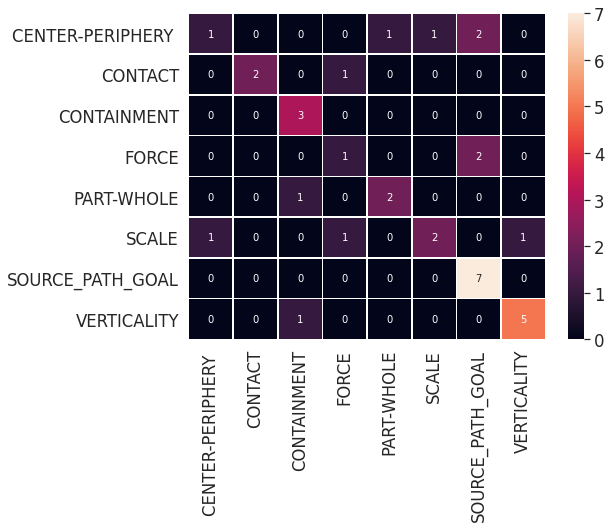

In [ ]:
_,_,_,_=validate(test_dataloader_ru, xlmr_model, True, True)

**French**

In [ ]:
df_french=pd.read_csv('Image Schemas French.csv')  
df_french

SuperordinateSchema  ... Notes
0               OBJECT  ...   NaN
1    CENTER-PERIPHERY   ...   NaN
2          CONTAINMENT  ...   NaN
3                FORCE  ...   NaN
4                SCALE  ...   NaN
5               OBJECT  ...   NaN
6               OBJECT  ...   NaN
7                 PATH  ...   NaN
8           PART-WHOLE  ...   NaN
9    CENTER-PERIPHERY   ...   NaN
10                PATH  ...   NaN
11              OBJECT  ...   NaN
12         CONTAINMENT  ...   NaN
13               SCALE  ...   NaN
14         CONTAINMENT  ...   NaN
15             CONTACT  ...   NaN
16          PART-WHOLE  ...   NaN
17                PATH  ...   NaN
18         CONTAINMENT  ...   NaN
19             CONTACT  ...   NaN
20                PATH  ...   NaN
21         CONTAINMENT  ...   NaN
22               SCALE  ...   NaN
23         CONTAINMENT  ...   NaN
24         VERTICALITY  ...   NaN
25               SCALE  ...   NaN
26          PART-WHOLE  ...   NaN
27   CENTER-PERIPHERY   ...   NaN
28             CONTACT  ...   NaN
29   CENTER-PERIPHERY   ...   NaN
30                PATH  ...   NaN
31   CENTER-PERIPHERY   ...   NaN
32         VERTICALITY  ...   NaN
33               SCALE  ...   NaN
34         VERTICALITY  ...   NaN
35         VERTICALITY  ...   NaN
36               FORCE  ...   NaN
37             CONTACT  ...   NaN
38             CONTACT  ...   NaN
39         VERTICALITY  ...   NaN
40               FORCE  ...   NaN
41               SCALE  ...   NaN
42               FORCE  ...   NaN
43               FORCE  ...   NaN

[44 rows x 5 columns]

In [ ]:
df_french = df_french[df_french.SuperordinateSchema != "LINK"]
df_french = df_french[df_french.SuperordinateSchema != "OBJECT"]
df_french = df_french[df_french.SuperordinateSchema != "SUBSTANCE"]
df_french["SuperordinateSchema"]=df_french["SuperordinateSchema"].replace("PATH", "SOURCE_PATH_GOAL")
df_french["SuperordinateSchema"]=le.transform(df_french["SuperordinateSchema"])

In [ ]:
input_ids_test_fr, attn_masks_test_fr, labels_all_test_fr = tokenizer_xlm(df_french, max_len)
test_dataset_fr = TensorDataset(input_ids_test_fr, attn_masks_test_fr, labels_all_test_fr)
test_dataloader_fr = DataLoader(test_dataset_fr, sampler = SequentialSampler(test_dataset_fr),batch_size = batch_size ) #sequential sampling

Encoder finished. 40 examples.


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       1.00      0.40      0.57         5
           2       0.43      1.00      0.60         6
           3       1.00      0.60      0.75         5
           4       0.00      0.00      0.00         3
           5       1.00      0.33      0.50         6
           6       0.38      0.60      0.46         5
           7       1.00      1.00      1.00         5

    accuracy                           0.60        40
   macro avg       0.66      0.57      0.55        40
weighted avg       0.70      0.60      0.58        40



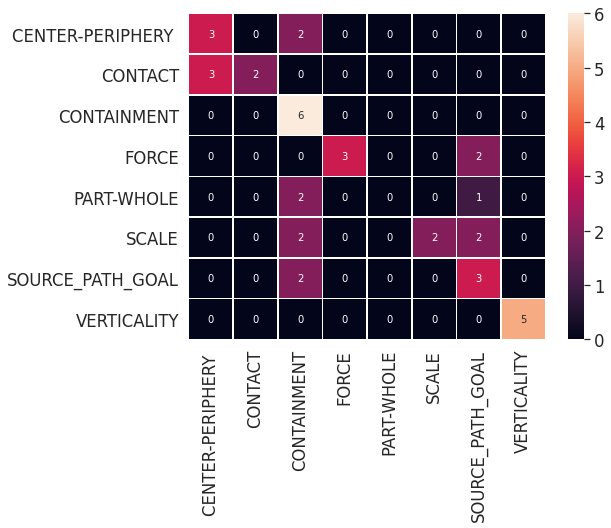

In [ ]:
_,_,_,_=validate(test_dataloader_fr, xlmr_model, True, True)

# Random Search and Learning Curve

In [ ]:
def randomsearch(parameter_list, data_train):
  
  print("Starting Random Search")

  results=[] 

  for i, parameters in enumerate(parameter_list):
    #load parameter
    model_name=parameters["model_name"]
    batch_size=parameters["batch_size"]
    lr=parameters["lr"]
    eps=parameters["eps"]
    max_len=parameters["max_len"]
    epochs=parameters["epochs"]
    warmup_steps=parameters["warmup_steps"]
    random_seed=parameters["random_seed"]

    print("\n"+"\033[1m"+"============== Iteration "+str(i+1)+"/"+str(len(parameter_list))+" =============="+"\033[0m"+"\n")
    print(parameters)

    #prepare input
    xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
    input_ids_train, attn_masks_train, labels_train = tokenizer_xlm(data_train, max_len)
    tensor_data_train = TensorDataset(input_ids_train, attn_masks_train, labels_train)
    train_dataloader = DataLoader(
                tensor_data_train,  
                sampler = RandomSampler(tensor_data_train), 
                batch_size = batch_size 
            )
    #create model
    xlmr_model, optimizer, scheduler = create_model(lr, eps, train_dataloader, epochs, device) 
    #train
    training_stats=train_model(epochs=epochs, 
                           xlmr_model=xlmr_model, 
                           train_dataloader=train_dataloader, 
                           validation_dataloader=test_dataloader,
                           random_seed=i,
                           verbose=False,
                           scheduler=scheduler,
                           optimizer=optimizer)
    
    df_stats = pd.DataFrame(data=training_stats)
    results.append((parameters,
                    training_stats[len(training_stats)-1]["Valid. Loss all"],
                    min(df_stats["Valid. Loss all"]),
                    training_stats[len(training_stats)-1]['Weigh_F1 all']))
  return results

In [ ]:
#parameter list for random search
parameter_grid_distr={
    "model_name":["xlm-roberta-base"],
    "lr":[3e-5],
    "eps":[1e-8],
    "max_len":[64], 
    "epochs":[12], 
    "warmup_steps":[0],
    "weight_decay":[0], 
    "batch_size":[16], 
    "random_seed": [1,2,3,4]
    }


param_list = list(ParameterSampler(parameter_grid_distr, n_iter=3))
param_list

In [ ]:
data_train_90perc=train_data_all.sample(frac=0.9)
data_train_80perc=train_data_all.sample(frac=0.8)
data_train_70perc=train_data_all.sample(frac=0.7)
data_train_60perc=train_data_all.sample(frac=0.6)
data_train_50perc=train_data_all.sample(frac=0.5)
data_train_40perc=train_data_all.sample(frac=0.4)
data_train_30perc=train_data_all.sample(frac=0.3)
data_train_20perc=train_data_all.sample(frac=0.2)
data_train_10perc=train_data_all.sample(frac=0.1)
train_sets=[train_data_all,data_train_90perc,data_train_80perc,data_train_70perc,data_train_60perc,data_train_50perc,data_train_40perc,data_train_30perc,data_train_20perc,data_train_10perc]
data_train_10perc

In [ ]:
learning_curve_data_x=[]
learning_curve_data_y=[]
for train_set in train_sets:
  print("Length of trainset:", len(train_set))
  results = randomsearch(param_list, train_set)
  max=0
  for r in results:
    if r[3]>max: 
      max=r[3]
  print("max:",max)
  sum=0
  for r in results:
    sum+=r[3]
  avg=sum/len(results)
  learning_curve_data_x.append(len(train_set))
  learning_curve_data_y.append(avg)

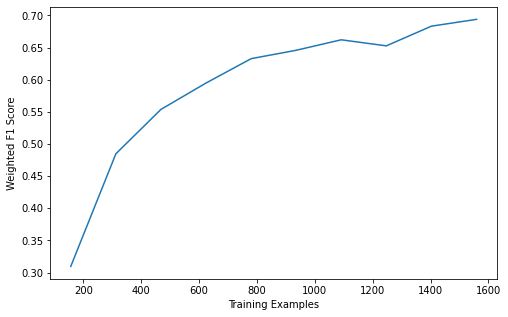

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(learning_curve_data_x, learning_curve_data_y)
plt.ylabel('Weighted F1 Score')
plt.xlabel('Training Examples')
plt.show()